In [1]:
from model.carvana_unet import load_UNet
import torch

device = 'cuda'
model = load_UNet("../inference/param/unet.pth", device)

/home/henry/Desktop/USAAIO/code/inference/model/carvana_unet.py:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(checkpoint_path, map_location=device)


In [2]:
from PIL import Image
import torchvision.transforms.functional as TF

img_path = '../dataset/carvana_unet/train_inputs/input_3.jpg'
mask_path = '../dataset/carvana_unet/train_outputs/output_3.gif'

with Image.open(img_path) as im:
    img = TF.pil_to_tensor(im).float().to(device) / 255

with Image.open(mask_path) as im:
    masks = TF.pil_to_tensor(im).float().to(device) / 255

mask_pred = model(img.unsqueeze(0))

OutOfMemoryError: CUDA out of memory. Tried to allocate 150.00 MiB. GPU 0 has a total capacity of 3.94 GiB of which 70.31 MiB is free. Including non-PyTorch memory, this process has 3.80 GiB memory in use. Of the allocated memory 3.69 GiB is allocated by PyTorch, and 56.22 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [106]:
import torch.nn as nn

bce_loss = nn.BCEWithLogitsLoss()

def dice_loss(pred, target, smooth=1e-6):
    pred = torch.sigmoid(pred)
    inter = (pred * target).sum(dim=(1,2,3))
    union = pred.sum(dim=(1,2,3)) + target.sum(dim=(1,2,3))
    dice = (2. * inter + smooth) / (union + smooth)
    return 1 - dice.mean()

def combined_loss(logits, target):
    return 0.2 * bce_loss(logits, target) + 0.8 * dice_loss(logits, target)

In [107]:
print(combined_loss(mask_pred, masks.unsqueeze(0)).item())

1.3069274425506592


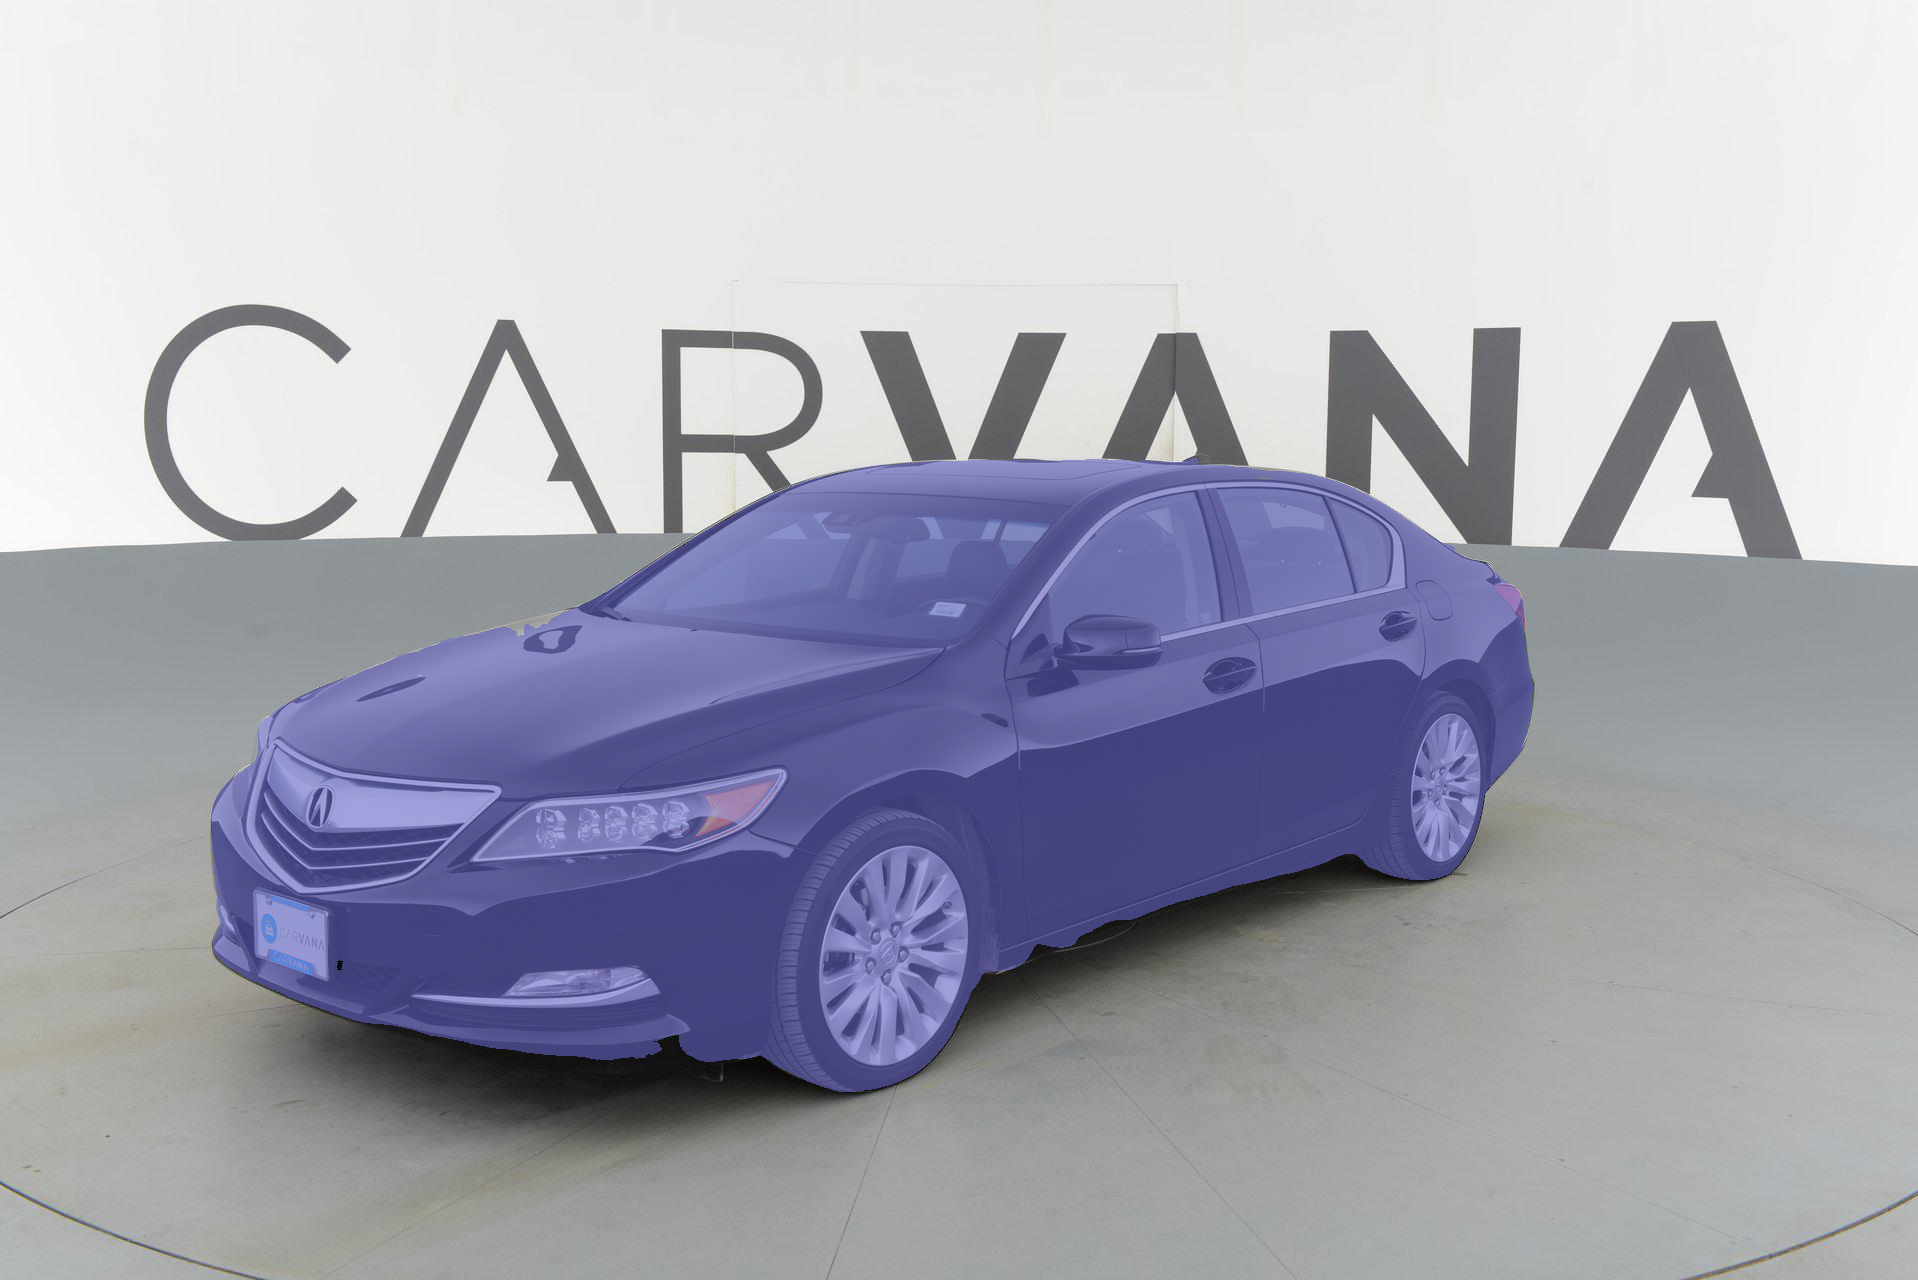

In [108]:
from torchvision import transforms as T
from torchvision.transforms import functional as TF
from PIL import Image

mask_pred = (torch.sigmoid(mask_pred) > 0.5).float()
mask_img = TF.to_pil_image(mask_pred.squeeze(0).cpu())
img_pil = TF.to_pil_image(img.cpu())

img_rgba = img_pil.convert("RGBA")
mask_rgba = mask_img.convert("RGBA")

overlay = Image.new("RGBA", mask_rgba.size, (100, 100, 200, 100))
mask_alpha = mask_pred.squeeze(0).mul(150).byte().cpu()
alpha_img = TF.to_pil_image(mask_alpha)
overlay.putalpha(alpha_img)

composite = Image.alpha_composite(img_rgba, overlay)
composite_rgb = composite.convert("RGB")

composite_rgb

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

